In [1]:
# Make sure you can import them before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import gzip
import struct
import time
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
#MNIST urls
url_base = 'http://yann.lecun.com/exdb/mnist/'
training_set_images = 'train-images-idx3-ubyte.gz' #size in bytes 9912422
training_set_labels = 'train-labels-idx1-ubyte.gz' #size in bytes 28881
test_set_images = 't10k-images-idx3-ubyte.gz' #size in bytes 1648877
test_set_labels = 't10k-labels-idx1-ubyte.gz' #size in bytes 4542
last_percent_reported = None
# Change me to store data elsewhere
data_root = 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data'

In [3]:
"""A hook to report the progress of a download. This is mostly intended for users with
   slow internet connections. Reports every 5% change in download progress.
"""
def download_progress_hook(count, blockSize, totalSize):  
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)
  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

In [4]:
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url_base + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

In [5]:
train_filename_images = maybe_download(training_set_images, 9912422)
train_filename_labels = maybe_download(training_set_labels, 28881)
test_filename_images = maybe_download(test_set_images, 1648877)
test_filename_labels = maybe_download(test_set_labels, 4542)

Found and verified D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\train-images-idx3-ubyte.gz
Found and verified D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\train-labels-idx1-ubyte.gz
Found and verified D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\t10k-images-idx3-ubyte.gz
Found and verified D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\t10k-labels-idx1-ubyte.gz


In [6]:
# read labels to an array
def make_labels_array_from_file(file_gzipped):
    # it sets byte stream from LABELS FOR TRAINING to a right position
    gzipFile_TrainLabels = gzip.open(file_gzipped)
    magicNumberLabels = int.from_bytes(gzipFile_TrainLabels.read(4), byteorder='big') #2049
    numberOfLabels = int.from_bytes(gzipFile_TrainLabels.read(4), byteorder='big') #60000
    print ('magicNumberLabels = ', magicNumberLabels, '\t','numberOfLabels = ', numberOfLabels)
    labels = np.ndarray(shape=(numberOfLabels, 1), dtype=np.int32)
    for i in range (numberOfLabels):
        #read label
        #label = 0
        label = int.from_bytes(gzipFile_TrainLabels.read(1), byteorder='big')
        labels[i, :] = label
    gzipFile_TrainLabels.close()    
    return labels

In [7]:
start_l = time.time()
labels_train = make_labels_array_from_file(train_filename_labels)
end_l = time.time()
print('time spent for creating array of labels to train = ', end_l - start_l, ' s')
print('\n')
start_l2 = time.time()
labels_test = make_labels_array_from_file(test_filename_labels)
end_l2 = time.time()
print('time spent for creating array of labels to train = ', end_l2 - start_l2, ' s')

magicNumberLabels =  2049 	 numberOfLabels =  60000
time spent for creating array of labels to train =  0.17951607704162598  s


magicNumberLabels =  2049 	 numberOfLabels =  10000
time spent for creating array of labels to train =  0.029078006744384766  s


In [8]:
# check arrays
print ('labels_train.shape = ', labels_train.shape)
for i in range (5):
    print (labels_train[i])
print ('labels_test.shape = ', labels_test.shape)
for i in range (5):
    print (labels_test[i])

labels_train.shape =  (60000, 1)
[5]
[0]
[4]
[1]
[9]
labels_test.shape =  (10000, 1)
[7]
[2]
[1]
[0]
[4]


In [9]:
NUMBER_FEATURES = 784; #square 28*28 as from data set -> array 784 items
# read images to an array
def make_images_array_from_file(file_gzipped):
    #it sets byte stream from IMAGES FOR TRAINING to a right position
    gzipFile_TrainImages = gzip.open(file_gzipped)
    magicNumberImages = int.from_bytes(gzipFile_TrainImages.read(4), byteorder='big') #2051
    numberOfImages = int.from_bytes(gzipFile_TrainImages.read(4), byteorder='big') #60000
    numberOfRows = int.from_bytes(gzipFile_TrainImages.read(4), byteorder='big') #28
    numberOfColumns = int.from_bytes(gzipFile_TrainImages.read(4), byteorder='big') #28
    print (magicNumberImages, '\t',numberOfImages, '\t', numberOfRows, '\t', numberOfColumns)
    # then, it reads the rest of the file to an array    
    
    #it creates n-dim array with picture as 784 features and an appropriate label
    datasetMnist = np.ndarray(shape=(numberOfImages, NUMBER_FEATURES), dtype=np.int32) #it creates a 2d array of 32-bit integers
    
    for i in range (numberOfImages):
        #read and create array for 784 features
        imagePixelsAsFeatures = np.ndarray(shape=(NUMBER_FEATURES), dtype=np.int32)
        for index in range(NUMBER_FEATURES):
            imagePixelsAsFeatures[index] = int.from_bytes(gzipFile_TrainImages.read(1), byteorder='big')        
        # put label and features to a dataset
        datasetMnist[i, :] = imagePixelsAsFeatures    
    gzipFile_TrainImages.close()
    return datasetMnist    

In [10]:
start_i = time.time()
images_train = make_images_array_from_file(train_filename_images)
end_i = time.time()
print('time spent for creating array of images to train = ', end_i - start_i, ' s')
print ('\n')
start_i = time.time()
images_test = make_images_array_from_file(test_filename_images)
end_i = time.time()
print('time spent for creating array of images to test = ', end_i - start_i, ' s')

2051 	 60000 	 28 	 28
time spent for creating array of images to train =  96.95532011985779  s


2051 	 10000 	 28 	 28
time spent for creating array of images to test =  16.453774452209473  s


In [11]:
# check array
print (images_train.shape)
image_five = images_train[0]
print (image_five)
# for i in range (10):
#     print (images_train[i])

(60000, 784)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0  

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

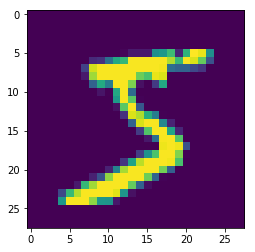

In [12]:
image_five_reshaped = images_train[0].reshape(28, 28)
print (image_five_reshaped)
plt.imshow(image_five_reshaped)

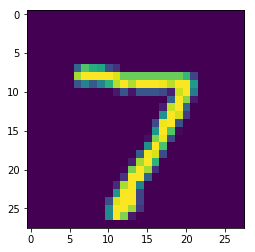

In [13]:
image_from_test_reshaped = images_test[0].reshape(28, 28)
plt.imshow(image_from_test_reshaped)

In [14]:
print(labels_test[0])

[7]


In [15]:
#save a images
imageio.imwrite(data_root + '\\extracted_from_mnist\\image_five' + '.png', image_five_reshaped[:])
imageio.imwrite(data_root + '\\extracted_from_mnist\\image_seven' + '.png', image_from_test_reshaped[:])

C:\Other_IT\Anaconda\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from int32 to uint8, range [0, 255]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [16]:
#TODO dump the arrays to a file?
#now we have:
#labels_train
#labels_test
#images_train
#images_test
#image_five
#image_five_reshaped
#image_from_test_reshaped
#it's time to create an train NN!

log_regr = LogisticRegression(solver='sag', multi_class='ovr', n_jobs=1)

In [17]:
# it can get lots of time to rain Neural Network
start_lr = time.time()
log_regr.fit(images_train,labels_train)
end_lr = time.time()
print ('time spent for training NN = ', end_lr - start_lr, ' s') 
# DataConversionWarning A column-vector y was passed when a 1d array was expected. 
# Please change the shape of y to (n_samples, ), for example using ravel().
# y = column_or_1d(y, warn=True)

C:\Other_IT\Anaconda\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Other_IT\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


time spent for training NN =  525.9357647895813  s


In [18]:
score = log_regr.score(images_test,labels_test)
print(score) # 0.9182 for LogisticRegression(solver='sag', multi_class='ovr', n_jobs=1)

0.9182


In [19]:
#dump model to a file
print ('Saving model to a file ... ')
filename_for_log_regr = data_root + '\\finalized_model_log_regr_MNIST_60K_solver_sag_ovr.sav'
pickle.dump(log_regr, open(filename_for_log_regr, 'wb'))
print ('Model saved.')

Saving model to a file ... 
Model saved.


In [20]:
#check it with detection on real images
def detect_digit_from_image(image_name_in_dataroot):
    my_gray = data_root + image_name_in_dataroot
    my_gray_data = imageio.imread(my_gray)
    plt.imshow(my_gray_data)
    print(my_gray_data.shape)
    nx_img, ny_img = my_gray_data.shape
    reshaped_my_gray_data = my_gray_data.reshape(nx_img*ny_img)
    print (reshaped_my_gray_data.shape)
    reshaped_2d_array = reshaped_my_gray_data.reshape(-784, 784)
    predicted = log_regr.predict(reshaped_2d_array)
    print (predicted)

(28, 28)
(784,)
[5]


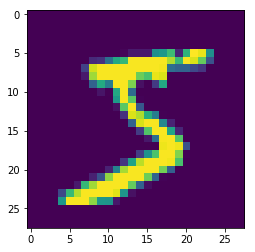

In [21]:
# PREDICT image with 5
detect_digit_from_image('\\extracted_from_mnist\\image_five' + '.png') # 5

(28, 28)
(784,)
[7]


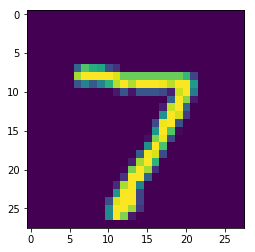

In [22]:
# PREDICT image with 7
detect_digit_from_image('\\extracted_from_mnist\\image_seven' + '.png') # 7

(28, 28)
(784,)
[8]


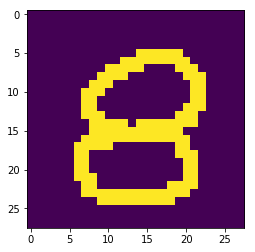

In [23]:
# PREDICT image with 8
detect_digit_from_image('\\my_digits\\image_eight_2' + '.bmp') # 8

(28, 28)
(784,)
[3]


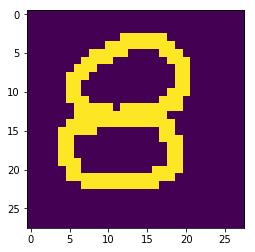

In [24]:
# PREDICT image with 8 again
detect_digit_from_image('\\my_digits\\image_eight' + '.bmp') # 3 - it is a case with when logistic regression failures

In [25]:
print ("YOU'VE DONE! LET'S DO SOME TRAIN WITH TENSORFLOW!")

YOU'VE DONE! LET'S DO SOME TRAIN WITH TENSORFLOW!
